In [1]:
import os
import gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from fmi_mlc import fmi_gym
from config import parameter as PARAMS

# Crear carpetas de logs y modelos si no existen
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Callback para guardar recompensas
class StepRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.raw_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        info = self.locals["infos"][0]
        raw_r = float(info.get("raw_reward", 0.0))
        self.raw_rewards.append(raw_r)
        self.timesteps.append(self.num_timesteps)
        return True

    def _on_training_end(self) -> None:
        np.savez(
            "logs/dqn_rewards_schedules.npz",
            timesteps=np.array(self.timesteps, dtype=np.int32),
            raw_rewards=np.array(self.raw_rewards, dtype=np.float32)
        )

# Wrapper para transformar acción discreta a vector binario (0s y 1s)
class ScheduleActionWrapper(gym.Wrapper):
    def __init__(self, base_env):
        super().__init__(base_env)
        self.action_dim = len(PARAMS["action_names"])
        self.observation_space = gym.spaces.Box(
            low=-100.0, high=100.0, shape=(len(PARAMS["observation_names"]),), dtype=np.float32
        )
        self.action_space = gym.spaces.Discrete(2 ** self.action_dim)
        self.prev_pmv = np.zeros(len(PARAMS["reward_names"]), dtype=np.float32)

    def reset(self, **kwargs):
        self.prev_pmv = np.zeros(len(PARAMS["reward_names"]), dtype=np.float32)
        return self.env.reset(**kwargs)

    def step(self, action):
        binary = np.array(list(np.binary_repr(action, width=self.action_dim)), dtype=np.float32)
        obs, rewards, done, info = self.env.step(binary)

        current_pmv = np.array(rewards, dtype=np.float32)
        reward = -np.sum(np.abs(current_pmv))  # Minimizar disconfort térmico (|PMV|)
        self.prev_pmv = current_pmv.copy()

        info = info.copy()
        info["raw_reward"] = reward
        return obs, reward, done, info

# Función para crear entorno
def make_env():
    base = fmi_gym(PARAMS)
    return ScheduleActionWrapper(base)

# Inicializar entorno y callback
env = DummyVecEnv([make_env])
callback = StepRewardLogger()

# Crear y entrenar modelo DQN
model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-5,
    buffer_size=100_000,
    learning_starts=1000,
    batch_size=8,
    gamma=0.99,
    train_freq=4,
    target_update_interval=500,
    exploration_fraction=0.3,
    exploration_final_eps=0.02,
    verbose=1
)

model.learn(total_timesteps=100_000, callback=callback)


/opt/conda/envs/simulation/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp77q_lc28//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:51
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializ

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57129.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57129.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp77q_lc28//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.05sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 21.18sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpif7gqi0j//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:51
Initializing Response 

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34799.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34799.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpif7gqi0j//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33105.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33105.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.71sec
Reading input and weather file for preprocessor program.


file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Office_IDF.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpjen08bq2//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][S

The IDF version of the input file ///tmp/JModelica.org/jm_tmpjen08bq2//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:52
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49089.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49089.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpkvadkuk6//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:52
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpujwy7heg//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:53
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39929.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39929.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpujwy7heg//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.29sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp3_esazil//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:53
Initializing Response 

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60685.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60685.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp3_esazil//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.51sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpfpgxe43d//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:54
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46025.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46025.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpfpgxe43d//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 24.59sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58759.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58759.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpppz6y4io//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:54
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51037.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51037.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

ort Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 S

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 25.06sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45453.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45453.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpoqmk8lgl//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpoqmk8lgl//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:55
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 24.84sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzpoi_b46//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:56
Initializing Response 

lave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzpoi_b46//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 25.05sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36643.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36643.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp3f7m5mqn//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

The IDF version of the input file ///tmp/JModelica.org/jm_tmp3f7m5mqn//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:56
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59965.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59965.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmplyj88469//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:57
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 25.60sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53463.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53463.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpy33g0qdk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

The IDF version of the input file ///tmp/JModelica.org/jm_tmpy33g0qdk//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:57
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 24.21sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58521.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58521.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpchn61a34//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpchn61a34//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:58
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpmgdcu25a//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:58
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59917.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59917.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpmgdcu25a//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.52sec
Reading input and weather file for preprocessor program.
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 136      |
|    time_elapsed     | 489      |
|    total_timesteps  | 66816    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 1.56     |
|    n_updates        | 16453    |
----------------------------------
The IDF version of the input file ///tmp/JModelica.org/jm_tmp2u0xpai0//resources//Office_IDF.idf starts with 

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56171.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56171.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp2u0xpai0//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.56sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp6gt4yzoh//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 06:59
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47255.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47255.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp6gt4yzoh//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.63sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp7g0dik22//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:00
Initializing Response 

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp7g0dik22//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.69sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55675.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55675.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_nvzauar//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

The IDF version of the input file ///tmp/JModelica.org/jm_tmp_nvzauar//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:00
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 22.85sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpxr5iascp//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:01
Initializing Response 

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45645.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45645.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpxr5iascp//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read director

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 23.03sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpmim5wbyo//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:01
Initializing Response 

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56735.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56735.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 4.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 10.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpmim5wbyo//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd 

UMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN DAY IN UNTITLED (01-01:31-12)
Adjusting Air System Sizing
A

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36031.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36031.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpai_a6hbq//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:02
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Rep

file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Office_IDF.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpai_a6hbq//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][S

Updating Shadowing Calculations, Start Date=06/22/2002
Updating Detailed Daylighting Factors, Start Date=06/22
Continuing Simulation at 06/22/2002 for UNTITLED (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 24.31sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 15638400.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 56.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45281.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45281.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp6i20gxap//resources//Office_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 2
This is the End Month: 6
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.18 07:02
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Encl

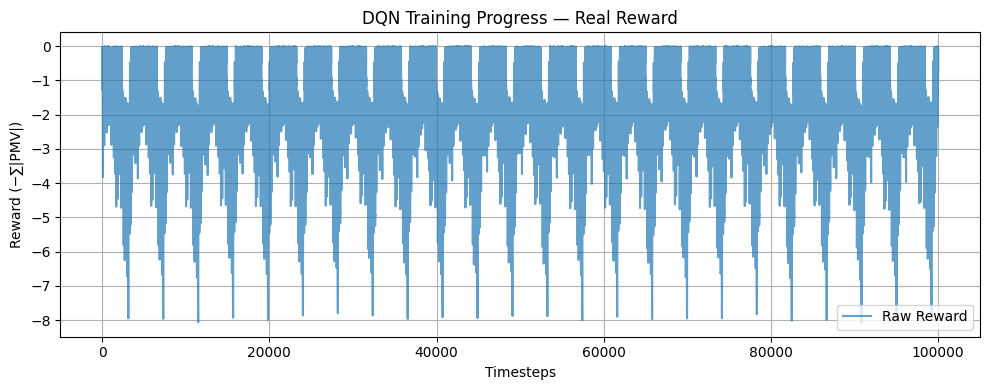

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar rewards guardados
data = np.load("logs/dqn_rewards_schedules.npz")
timesteps = data["timesteps"]
raw_rewards = data["raw_rewards"]

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(timesteps, raw_rewards, label="Raw Reward", alpha=0.7)
plt.xlabel("Timesteps")
plt.ylabel("Reward (−∑|PMV|)")
plt.title("DQN Training Progress — Real Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
model.save("/home/jovyan/controller_notebooks/test3_agent")